In [1]:
import os

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import feature
from skimage import filters
from skimage.io import imread
from skimage.transform import resize
import scipy

import pix2pix

In [2]:
path_root = os.path.abspath(os.path.expanduser('Dataset/dataset_voc/SegmentationClass'))
queue = [path_root]
npy_items = list()
while queue:
    ptr = queue.pop()
    for entry in os.scandir(ptr):
        if entry.name.startswith('.') or not entry.is_file():
            queue.append(entry.path)
        elif entry.name.endswith('.npy'):
            npy_items.append(entry.path)
npy_items.sort()
print(npy_items)

['/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_10.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_100.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_101.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_102.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_104.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_108.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_114.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_116.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_117.npy', '/home/harny/Github/cell-classification/Dataset/dataset_voc/SegmentationClass/hek293_100x_118.npy']


In [3]:
path_root = os.path.abspath(os.path.expanduser('Dataset/dataset_voc/JPEGImages'))
queue = [path_root]
jpg_items = list()
while queue:
    ptr = queue.pop()
    for entry in os.scandir(ptr):
        if entry.name.startswith('.') or not entry.is_file():
            queue.append(entry.path)
        elif entry.name.endswith('.jpg'):
            jpg_items.append(entry.path)
jpg_items.sort()
print(jpg_items)

['/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_10.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_100.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_101.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_102.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_104.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_108.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_114.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_116.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_117.jpg', '/home/harny/Github/cell-classification/Dataset/dataset_voc/JPEGImages/hek293_100x_118.jpg']


In [4]:
def preprocess(path):
    data = np.load(path)
    data = resize(data, (128, 128), anti_aliasing=False)
    data = np.round(data/np.max(data))
    data[data > 0] = data[data > 0] + 1 # Class label + 1
    edge = filters.sobel(data) # Find edge
    data[edge > 0] = 1 # Set class 1 to edge
    return data

In [5]:
x = list()
y = list()
for train, label in zip(jpg_items, npy_items):
    t = imread(train)
    t = resize(t, (128, 128), anti_aliasing=True)
    x.append(t)
    l = np.expand_dims(preprocess(label), axis=-1)
    y.append(l)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x, y))

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
OUTPUT_CHANNELS = 3

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [10]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

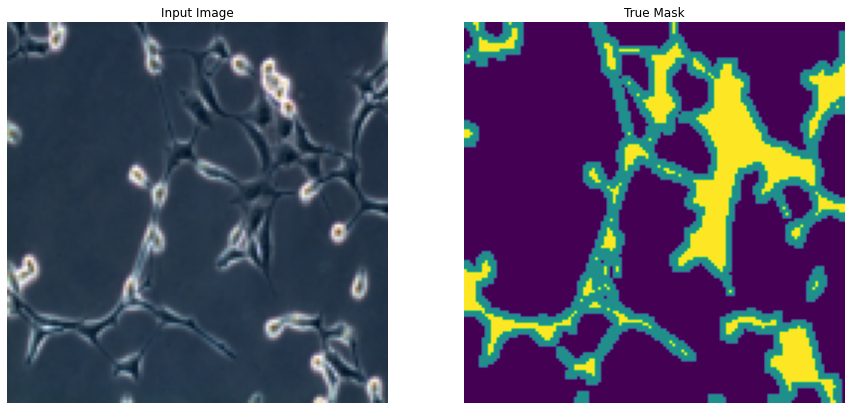

In [12]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

In [13]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
                   output_channels, 3, strides=2,
                   padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [16]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([x[0], y[0],
                 create_mask(model.predict(x[0][tf.newaxis, ...]))])

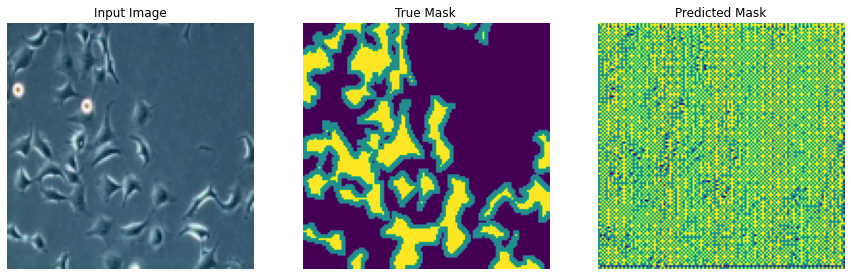

In [17]:
show_predictions()

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.5982 - accuracy: 0.2089


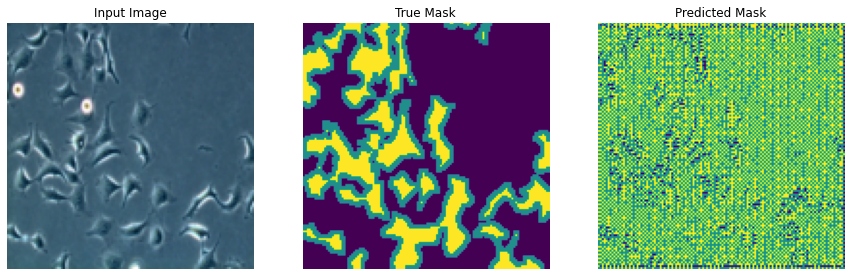


Sample Prediction after epoch 1

Epoch 2/20
1/1 [==============================] - 0s 342ms/step - loss: 1.2845 - accuracy: 0.2212


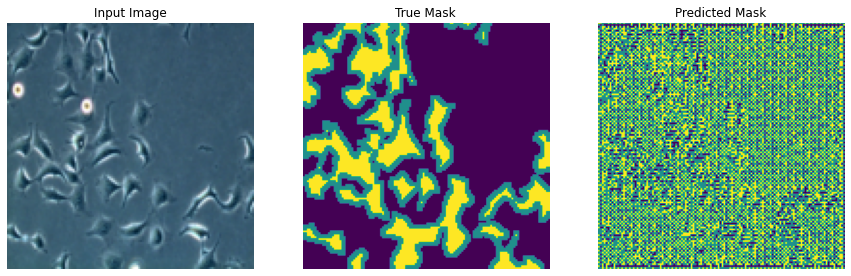


Sample Prediction after epoch 2

Epoch 3/20
1/1 [==============================] - 0s 404ms/step - loss: 1.0905 - accuracy: 0.3631


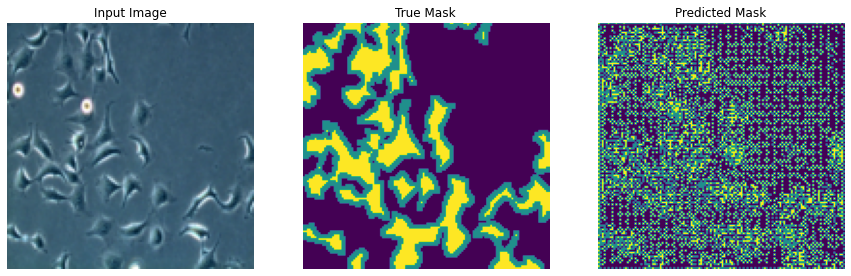


Sample Prediction after epoch 3

Epoch 4/20
1/1 [==============================] - 0s 331ms/step - loss: 0.9812 - accuracy: 0.5983


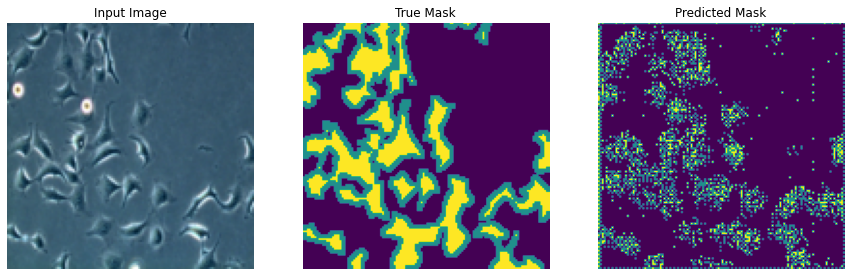


Sample Prediction after epoch 4

Epoch 5/20
1/1 [==============================] - 0s 297ms/step - loss: 0.9229 - accuracy: 0.6315


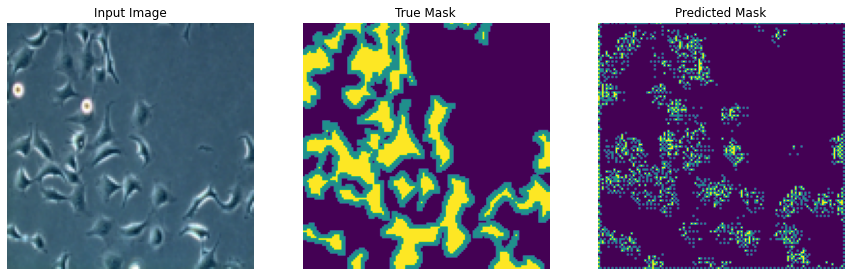


Sample Prediction after epoch 5

Epoch 6/20
1/1 [==============================] - 0s 305ms/step - loss: 0.8856 - accuracy: 0.6228


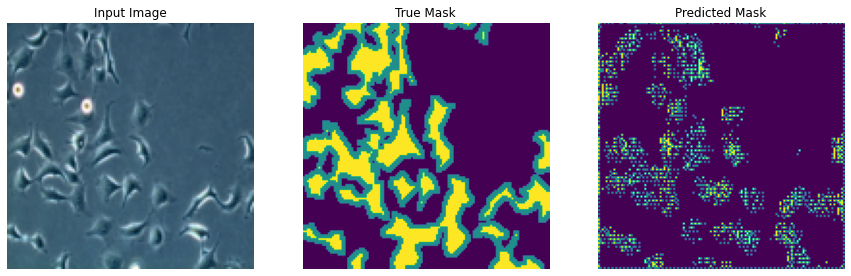


Sample Prediction after epoch 6

Epoch 7/20
1/1 [==============================] - 0s 374ms/step - loss: 0.8558 - accuracy: 0.6188


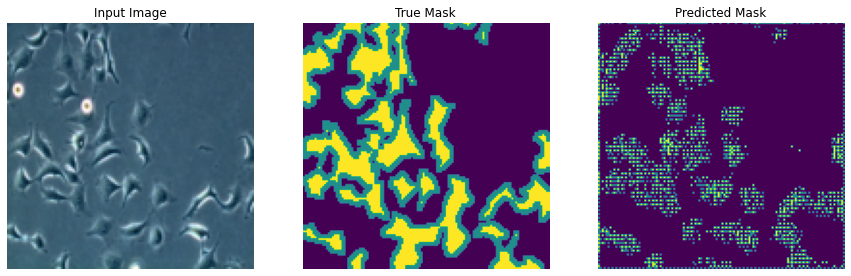


Sample Prediction after epoch 7

Epoch 8/20
1/1 [==============================] - 0s 333ms/step - loss: 0.8291 - accuracy: 0.6183


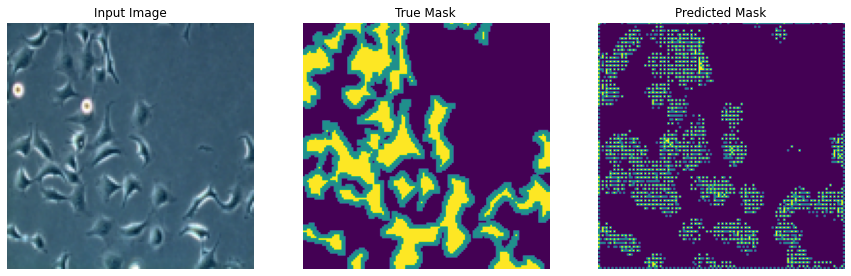


Sample Prediction after epoch 8

Epoch 9/20
1/1 [==============================] - 0s 306ms/step - loss: 0.8029 - accuracy: 0.6224


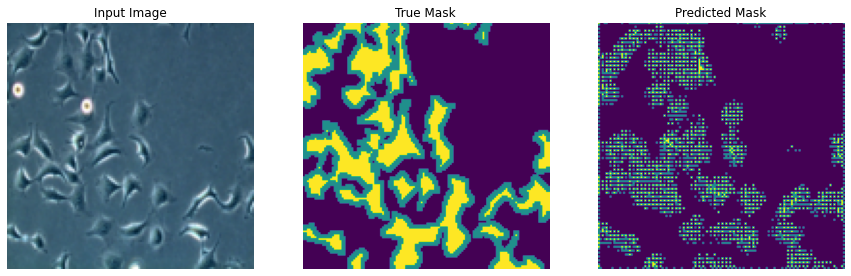


Sample Prediction after epoch 9

Epoch 10/20
1/1 [==============================] - 0s 316ms/step - loss: 0.7760 - accuracy: 0.6297


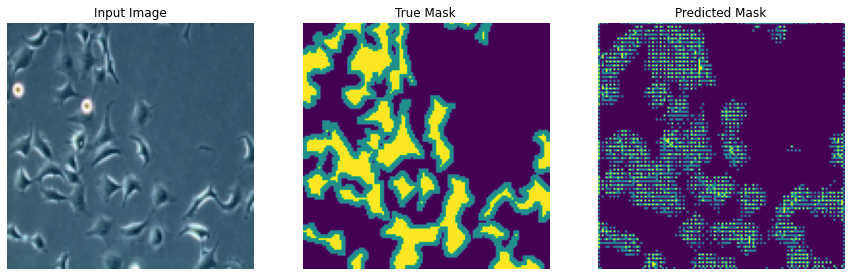


Sample Prediction after epoch 10

Epoch 11/20
1/1 [==============================] - 0s 301ms/step - loss: 0.7495 - accuracy: 0.6379


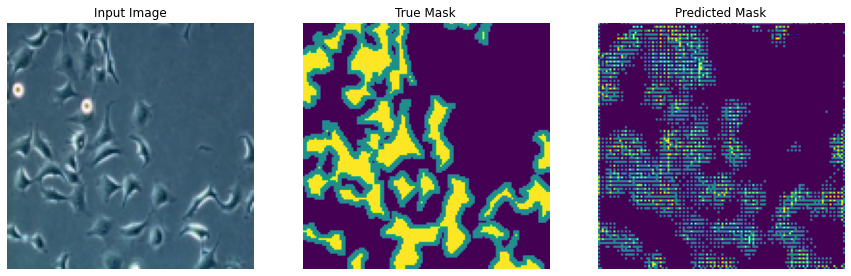


Sample Prediction after epoch 11

Epoch 12/20
1/1 [==============================] - 0s 305ms/step - loss: 0.7233 - accuracy: 0.6478


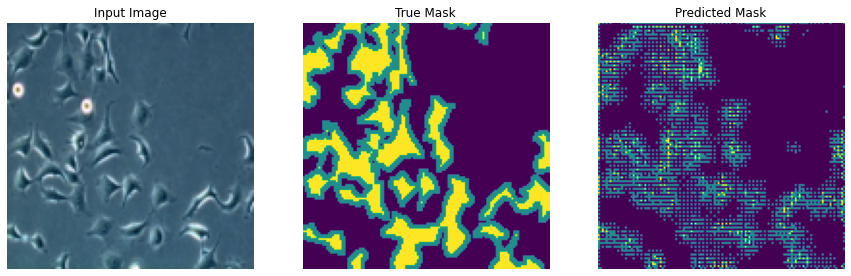


Sample Prediction after epoch 12

Epoch 13/20
1/1 [==============================] - 0s 345ms/step - loss: 0.6984 - accuracy: 0.6586


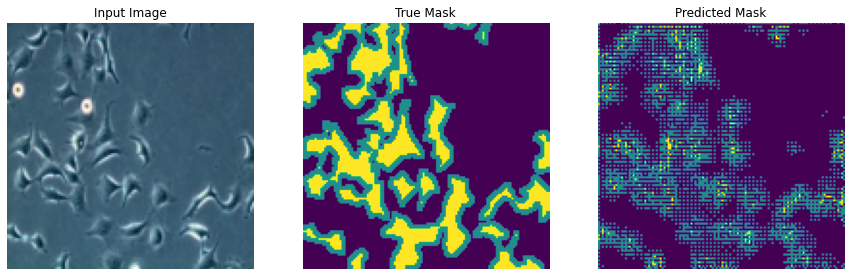


Sample Prediction after epoch 13

Epoch 14/20
1/1 [==============================] - 0s 318ms/step - loss: 0.6751 - accuracy: 0.6715


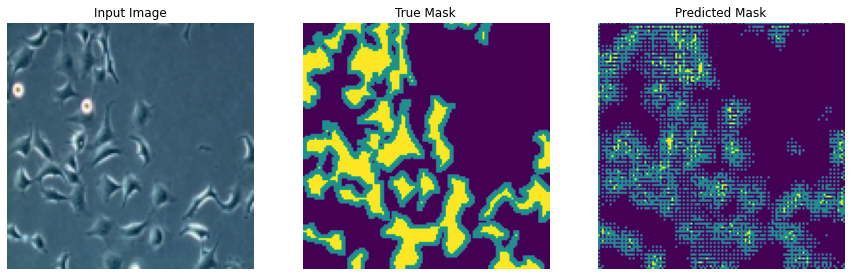


Sample Prediction after epoch 14

Epoch 15/20
1/1 [==============================] - 0s 355ms/step - loss: 0.6527 - accuracy: 0.6862


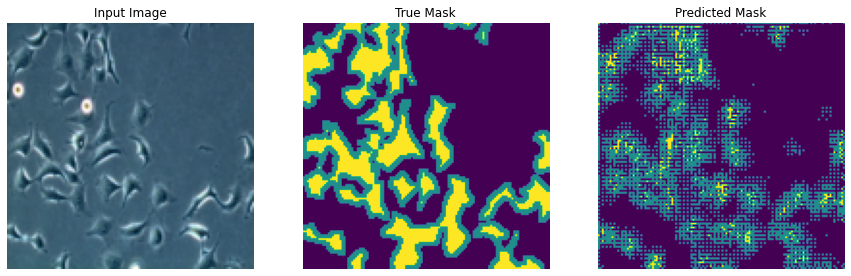


Sample Prediction after epoch 15

Epoch 16/20
1/1 [==============================] - 0s 294ms/step - loss: 0.6304 - accuracy: 0.7029


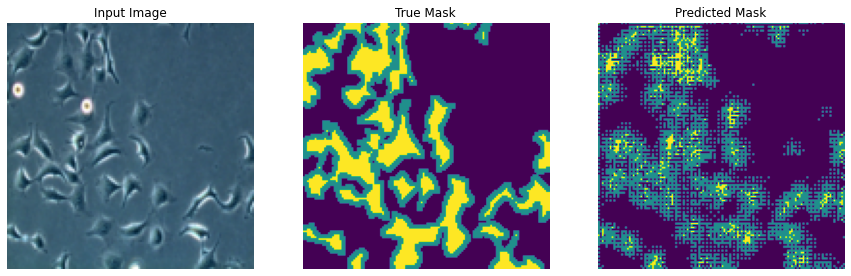


Sample Prediction after epoch 16

Epoch 17/20
1/1 [==============================] - 0s 311ms/step - loss: 0.6092 - accuracy: 0.7205


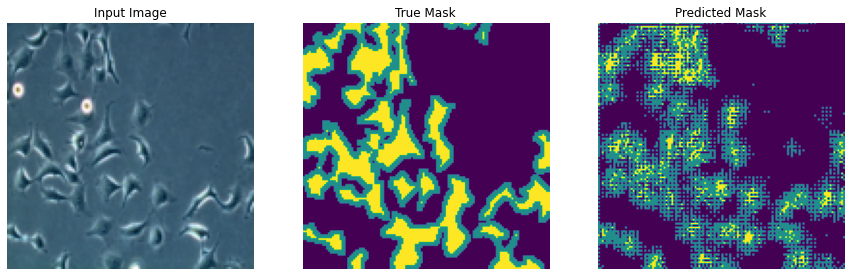


Sample Prediction after epoch 17

Epoch 18/20
1/1 [==============================] - 0s 300ms/step - loss: 0.5898 - accuracy: 0.7362


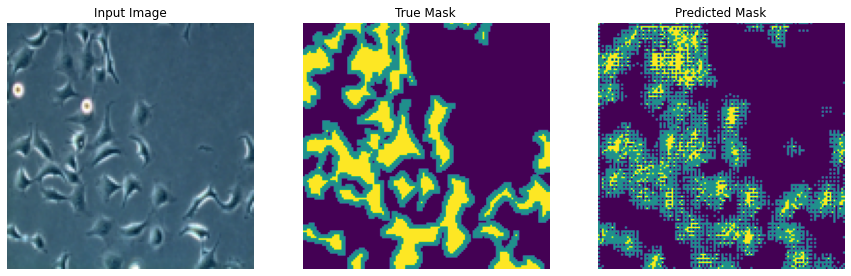


Sample Prediction after epoch 18

Epoch 19/20
1/1 [==============================] - 0s 313ms/step - loss: 0.5692 - accuracy: 0.7519


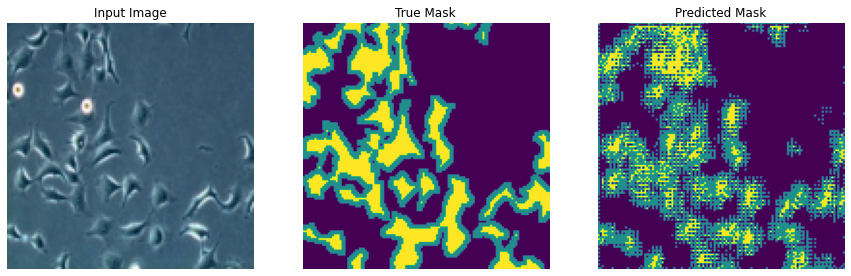


Sample Prediction after epoch 19

Epoch 20/20
1/1 [==============================] - 0s 320ms/step - loss: 0.5515 - accuracy: 0.7662


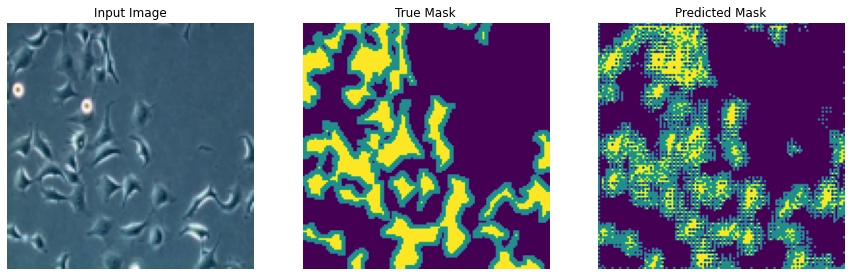


Sample Prediction after epoch 20



In [19]:
EPOCHS = 20

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          callbacks=[DisplayCallback()])

In [20]:
r = model.predict(np.expand_dims(x[0], axis=0))

In [21]:
pred_mask = tf.argmax(r, axis=-1)

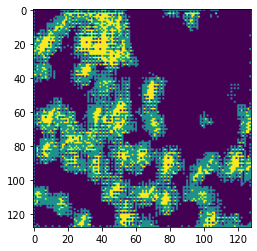

In [22]:
plt.imshow(pred_mask[0])